In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import numpy.linalg as npl
from scipy.sparse.linalg import cg

import pherosensor

from pheromone_dispersion.diffusion_operator import Diffusion
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

In [2]:
Lx = 20
Ly = 25
Delta_x = 0.4
Delta_y = 0.4
T_final = 5.

# Test of the numerical scheme of the diffusion operator

This notebook aims to test the implementation of the numerical scheme of the diffusion operator.

The diffusion operator is the operator $D:c\mapsto \nabla\cdot(\mathbf{K}(x,y)\nabla c(x,y))~\forall (x,y)\in\Omega$ such that $K\nabla c\cdot \vec{n} = 0~\forall(x,y)\in\partial\Omega$.

## Reference solution

To test this operator, we consider a diffusion tensor of shape $\mathbf{K}=diag(K_x,K_y)$.\
This implies that on the boundary of $\Omega=[O;L_x]\times[O;L_y]$, $\mathbf{K}\nabla c\cdot \vec{n} = \pm K_x\partial_xc$ for $x\in\{0,L_x\}$ and $\mathbf{K}\nabla c\cdot \vec{n} = \pm K_y\partial_yc$ for $y\in\{0,L_y\}$. 

In [3]:
K_x = 5./3.
K_y = 1.

def diffusion_tensor(msh): 
    
    U_hi = np.zeros((msh.y_horizontal_interface.size,msh.x.size,2))
    U_hi[:,:,0] = 1. 
    U_vi = np.zeros((msh.y.size,msh.x_vertical_interface.size,2))
    U_vi[:,:,0] = 1.
    U = Velocity(msh, U_vi, U_hi)
    return DiffusionTensor(U, K_x, K_y)

We also consider the reference solution $c^{ref}(x,y,t) =  cos\left(\frac{2\pi n_xx}{L_x}\right)+cos\left(\frac{2\pi n_yy}{L_y}\right)$.

In [4]:
nx = 5
ny = 7
lambda_x = 2 * np.pi * nx / Lx
lambda_y = 2 * np.pi * ny / Ly

def c_reference(x,y): 
    return np.cos(lambda_x * x) + np.cos(lambda_y * y)

Therefore, we have:\
$\partial_xc^{ref}(x,y)=-\frac{2\pi n_x}{L_x}sin\left(\frac{2\pi n_xx}{L_x}\right)$, $\partial_{xx}c^{ref}(x,y)=-\frac{4\pi^2 n_x^2}{L_x^2}cos\left(\frac{2\pi n_xx}{L_x}\right)$\
$\partial_yc^{ref}(x,y)=-\frac{2\pi n_y}{L_y}sin\left(\frac{2\pi n_yy}{L_y}\right)$, $\partial_{yy}c^{ref}(x,y)=-\frac{4\pi^2 n_y^2}{L_y^2}cos\left(\frac{2\pi n_yy}{L_y}\right)$\
We can note that the reference solution satisfies the boundary conditions

Hence, we have $Dc^{ref}(x,y) = \nabla\cdot(\mathbf{K}\nabla c^{ref}) = -K_x\frac{4\pi^2 n_x^2}{L_x^2}cos\left(\frac{2\pi n_xx}{L_x}\right)-K_y\frac{4\pi^2 n_y^2}{L_y^2}cos\left(\frac{2\pi n_yy}{L_y}\right)$

In [5]:
def Dc_reference(x,y): 
    return - K_x * lambda_x**2 * np.cos(lambda_x * x) - K_y * lambda_y**2 * np.cos(lambda_y * y)

## Numerical scheme

The numerical scheme used is a finite volume scheme. The average of the diffusion operator over a control volume $\Omega_{i,j}$ is : 
$\frac{1}{|\Omega_{i,j}|} \int_{\Omega_{i,j}} \nabla\cdot(\mathbf{K}(x,y) \nabla c(x,y))dx dy = \frac{1}{|\Omega_{i,j}|} \int_{\partial \Omega_{i,j}}\mathbf{K}(x,y) \nabla c(x,y)\cdot \vec{n} dx dy$. \
In the present case, we use uniform cartesian meshes with the same space step along the two axis. We will denote by the indexes $i+\frac{1}{2},j$ the vertical interface between the control volumes $i,j$ and $i+1,j$, and similarly for the horizontal interfaces. Moreover, let us note that on the vertical interfaces $\vec{n}=(\pm1,0)$ and on the horizontal interfaces $\vec{n}=(0,\pm1)$.\
Therefore, we have: $\frac{1}{|\Omega_{i,j}|} \int_{\partial \Omega_{i,j}}\mathbf{K}(x,y)\nabla c(x,y)\cdot \vec{n} dx dy \approx D^{solver}c(x_i,y_j) = \frac{1}{|\Omega_{i,j}|}\left(\Delta y\left(\mathbf{K}_{i+\frac{1}{2},j}\nabla c_{i+\frac{1}{2},j}-\mathbf{K}_{i-\frac{1}{2},j}\nabla c_{i-\frac{1}{2},j}\right)+\Delta x\left(\mathbf{K}_{i,j+\frac{1}{2}}\nabla c_{i,j+\frac{1}{2}}-\mathbf{K}_{i,j-\frac{1}{2}}\nabla c_{i,j-\frac{1}{2}}\right)\right)$\
The gradient at the interfaces are computed using a centered finite difference approximation:\
$\nabla c_{i+1/2,j} = \left(  \frac{c_{i+1,j}-c_{i,j}}{\Delta x}; \frac{c_{i+1/2,j+1/2}-c_{i+1/2,j-1/2}}{\Delta y}  \right)$ and $\nabla c_{i,j+1/2} = \left(\frac{c_{i+1/2,j+1/2}-c_{i-1/2,j+1/2}}{\Delta x}; \frac{c_{i,j+1}-c_{i,j}}{\Delta y}\right)$\
with the values at the angles computed by averaging the value of the cell sharing the angle, for instance: $c_{i+1/2,j+1/2} = \frac{c_{i,j}+c_{i+1,j}+c_{i,j+1}+c_{i+1,j+1}}{4}$

In [6]:
space_factor_a = [0.005, 0.01, 0.1, 1.]
dx_a = np.zeros(len(space_factor_a))

MAE = np.zeros(len(space_factor_a))
RMSE = np.zeros(len(space_factor_a))

for i, space_factor in enumerate(space_factor_a):
    
    msh = MeshRect2D(Lx, Ly, Delta_x*space_factor, Delta_y*space_factor, T_final)
    dx_a[i] = Delta_x*space_factor    
    x, y = np.meshgrid(msh.x, msh.y)
    
    c_ref = c_reference(x,y)
    Dc_ref = Dc_reference(x,y)
    
    K = diffusion_tensor(msh)
    D = Diffusion(K, msh)
    Dc_solver = D.matvec(c_ref.reshape((msh.y.size * msh.x.size,)))
    Dc_solver = Dc_solver.reshape((msh.y.size, msh.x.size))
    
    MAE[i] = np.mean(np.abs(Dc_solver - Dc_ref))
    RMSE[i] = npl.norm(Dc_solver - Dc_ref) / np.sqrt(Dc_ref.size)
    
    print("")
    print("dx = ", msh.dx)


dx =  0.002

dx =  0.004

dx =  0.04000000000000001

dx =  0.4


## Analysis of the truncation error
In the present case, since the diffusion tensor is diagonal and the mesh is uniform and cartesian (with $\Delta x = \Delta y$), the finite volume scheme is equivalent to a standard centered finite difference scheme.\
Hence, we have the truncation error $R(x,y) = |D^{solver}c(x,y) - Dc(x,y)|=\mathcal{O}(\Delta x^2)$.

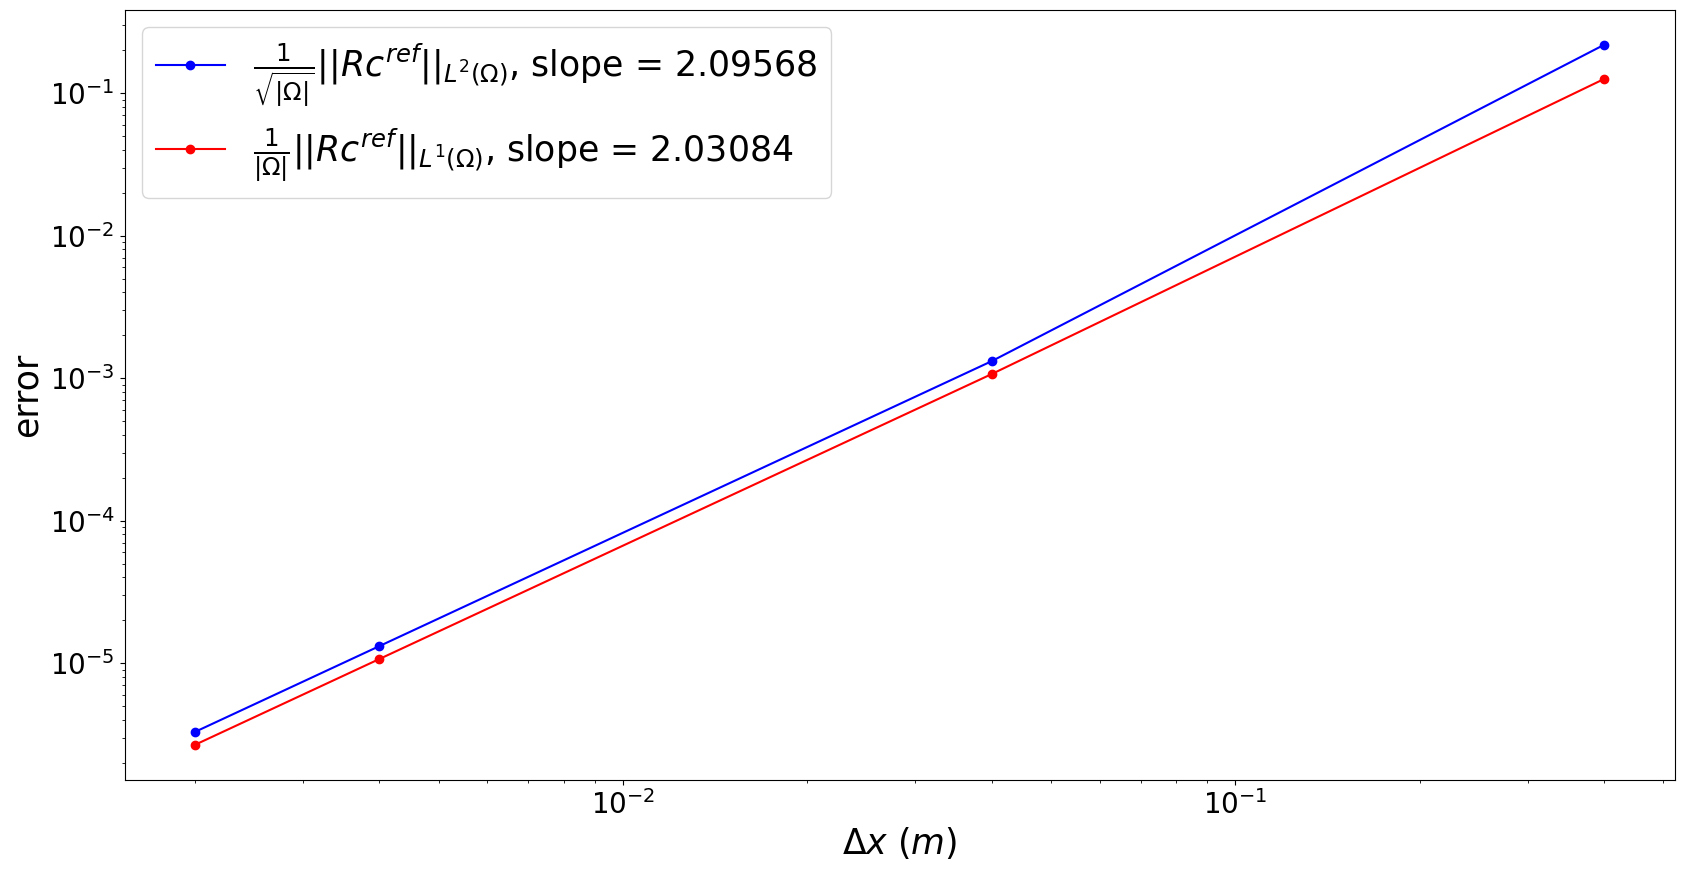

In [7]:
slope_MAE = (np.log(MAE[0]) - np.log(MAE[-1])) / (np.log(dx_a[0]) - np.log(dx_a[-1])) 
slope_RMSE = (np.log(RMSE[0]) - np.log(RMSE[-1]) ) / ( np.log(dx_a[0]) - np.log(dx_a[-1])) 

fontsize = 25
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(dx_a,RMSE,'-ob',label=r'$\frac{1}{\sqrt{|\Omega|}}||Rc^{ref}||_{L^2(\Omega)}$'+f', slope = {"{:.5f}".format(slope_RMSE)}')
ax1.plot(dx_a,MAE,'-or',label=r'$\frac{1}{|\Omega|}||Rc^{ref}||_{L^1(\Omega)}$'+f', slope = {"{:.5f}".format(slope_MAE)}')
ax1.tick_params(axis='both',labelsize=fontsize-5)
ax1.set_ylabel(r'error', fontsize=fontsize)
ax1.set_xlabel('$\Delta x$ ($m$)', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='upper left',prop={'size': fontsize})

# Scalar product test for the adjoint of the diffusion operator

Let us note that the diffusion operator is auto-adjoint: $D^*=D$, for a symmetric diffusion tensor $\mathbf{K}=\mathbf{K}^T$.

This section aims at performing the scalar product test for the diffusion operator. It also enables to check that the scheme of the diffusion operator is also auto-adjoint. 

The test of the scalar product consists in checking that $<Dc_1,c_2>\approx<c_1,D^*c_2>$ for any $c_1$ and $c_2$ (here picked randomly).

In [8]:
msh = MeshRect2D(Lx, Ly, Delta_x, Delta_y, T_final)
K = diffusion_tensor(msh)

D = Diffusion(K, msh)

np.random.seed(0)
c1 = np.random.normal(0, 1, size=msh.x.size*msh.y.size)
c2 = np.random.normal(0, 1, size=msh.x.size*msh.y.size)

prod_scal_D = np.dot(c2,D.matvec(c1))
prod_scal_DT = np.dot(c1,D.matvec(c2))

print("<Dc_1,c_2> = ",prod_scal_D)
print("<c_1,D*c_2> = ",prod_scal_DT)
print("|<Dc_1,c_2>-<c_1,D*c_2>| = ", np.abs(prod_scal_D-prod_scal_DT))

<Dc_1,c_2> =  1902.906719677645
<c_1,D*c_2> =  1902.9067196776446
|<Dc_1,c_2>-<c_1,D*c_2>| =  4.547473508864641e-13
